In [1]:
from collections import defaultdict

from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error as mse,
                             mean_squared_log_error as msle,
                             mean_absolute_error as mae,
                             r2_score, accuracy_score, classification_report)
from sklearn.base import clone

from IPython.display import display, HTML, Image

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
%matplotlib notebook

sns.set_style('whitegrid')

## Dataset Load & Transform
---
todo

In [237]:
ds = pd.read_csv('2016-09-19_79351_training.csv')
ds = ds.sample(frac=1).reset_index()

mcc_lookup = pd.read_csv('mcc_group_definition.csv').set_index('mcc_group').to_dict()
transaction_type_lookup = pd.read_csv('transaction_types.csv').set_index('type').to_dict()

In [238]:
def transform_dataset(ds, copy=False):
    if copy:
        ds = ds.copy()
    ds.transaction_date = pd.to_datetime(ds.transaction_date)
    ds['transaction_direction'] = ds.transaction_type.apply(
        lambda t: transaction_type_lookup['direction'][t]
    )
    ds['transaction_agent'] = ds.transaction_type.apply(
        lambda t: transaction_type_lookup['agent'][t]
    )
    
    ds['day'] = ds.transaction_date.apply(lambda d: d.day_name())
    ds['day_of_year'] = ds.transaction_date.apply(lambda d: d.dayofyear)
    ds['day_of_week'] = ds.transaction_date.apply(lambda d: d.dayofweek)
    ds['month'] = ds.transaction_date.apply(lambda d: d.month_name())
    return ds


def create_income_expenses_df(ds):
    in_idx  = ds.transaction_direction == 'In'
    out_idx = ds.transaction_direction == 'Out'
    
    user_finances = pd.concat([
        ds[in_idx].groupby(['user_id', 'month'])['amount_n26_currency'].sum().rename('in'),
        ds[in_idx].groupby(['user_id', 'month'])['amount_n26_currency'].count().rename('count_in'),
        ds[out_idx].groupby(['user_id', 'month'])['amount_n26_currency'].sum().rename('out'),
        ds[out_idx].groupby(['user_id', 'month'])['amount_n26_currency'].count().rename('count_out')
    ], join='outer', axis=1).fillna(0).reset_index()
    user_finances['net'] = user_finances['in'] - user_finances['out']
    
    return user_finances, in_idx, out_idx


ds = transform_dataset(ds)
user_finances, in_idx, out_idx = create_income_expenses_df(ds)


months = ['February', 'March', 'April', 'May', 'June', 'July']
days   = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

## Explore Dataset
---
todo

In [7]:
# TODO: move plot utils outside?
def plot_monthly_finance_distributions(idx_1, idx_2, label_1, label_2, log_transform=False):
    plt.rcParams['figure.figsize'] = (14, 6)
    plt.rcParams['figure.dpi'] = 50

    fig, axes = plt.subplots(2, 3)
    for i, month in enumerate(['February', 'March', 'April', 'May', 'June', 'July']):
        _axes = axes[i // 3, i % 3]

        for c, alpha, label, idx in [('g', .5, label_1, idx_1), ('r', .3, label_2, idx_2)]:
            if log_transform == True:
                target_var = np.log1p(user_finances[user_finances.month == month][idx])
            else:
                target_var = user_finances[user_finances.month == month][idx]

            sns.distplot(
                target_var, color=c, hist_kws={'alpha': alpha}, hist=True,
                label=label, kde=False, norm_hist=True, ax=_axes
            )
        _axes.set_xlabel('')
        _axes.set_title(month)
        _axes.legend()

In [ ]:
def plot_week_over_week(direction=None, transaction_type=None):
    assert direction in {'in', 'out'}
    week_over_week = {k: {'week_{}'.format(i): [] for i in range(5)} for k in months}

    fig, axes = plt.subplots(2, 3)

    for month in months:
        for day in range(7):
            idx = in_idx if direction == 'in' else out_idx
            idx = idx & (ds.transaction_type == transaction_type) if transaction_type else idx
            weekly_count = ds[idx & (ds.month == month) & (ds.day_of_week == day)].groupby('day_of_year').transaction_date.count().values
            for i, c in enumerate(weekly_count):
                week_over_week[month]['week_{}'.format(i)].append(c)

    for i, month in enumerate(months):
        _axes = axes[i // 3, i % 3]
        for week, counts in week_over_week[month].items():
            _axes.plot([days[i] for i in range(len(counts))], counts, label=week)
            _axes.legend()
            _axes.set_title(month)

<IPython.core.display.Javascript object>


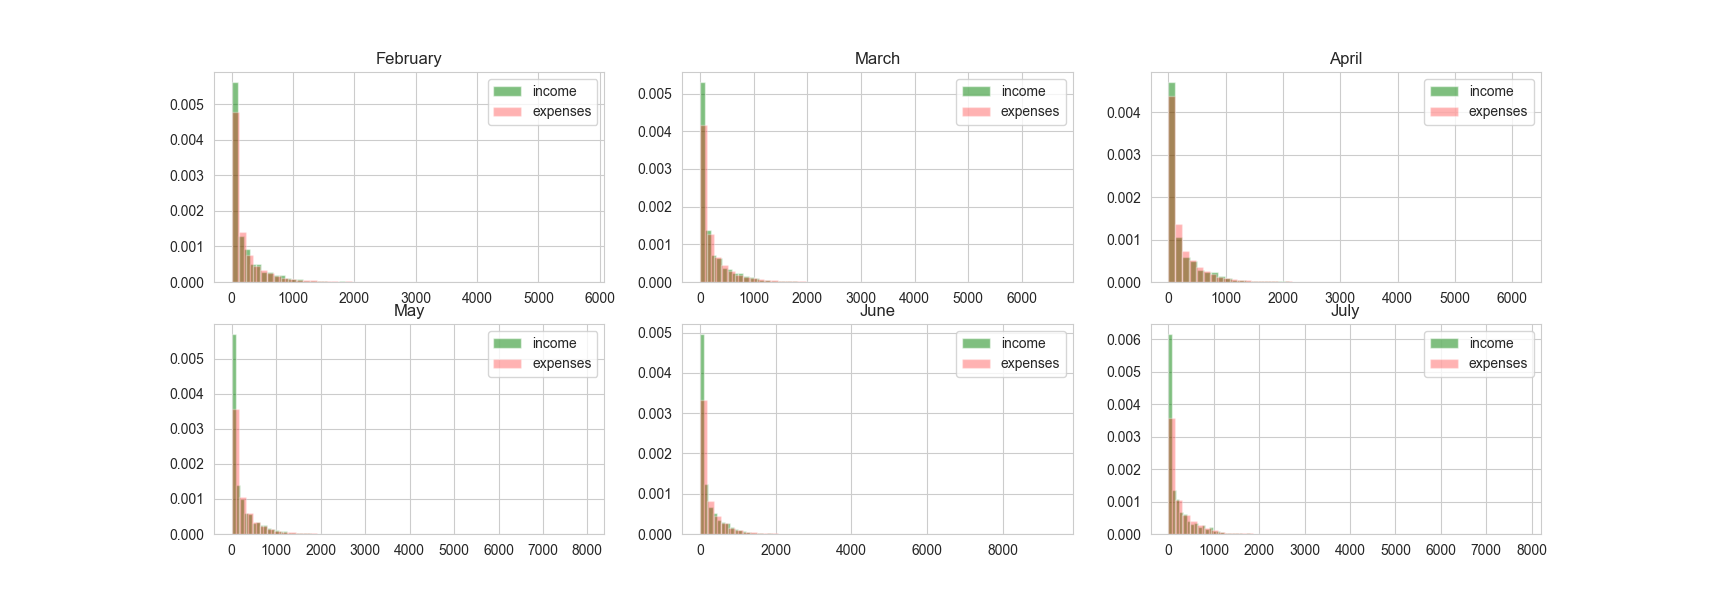

In [8]:
plot_monthly_finance_distributions('in', 'out', 'income', 'expenses', log_transform=False)

<IPython.core.display.Javascript object>


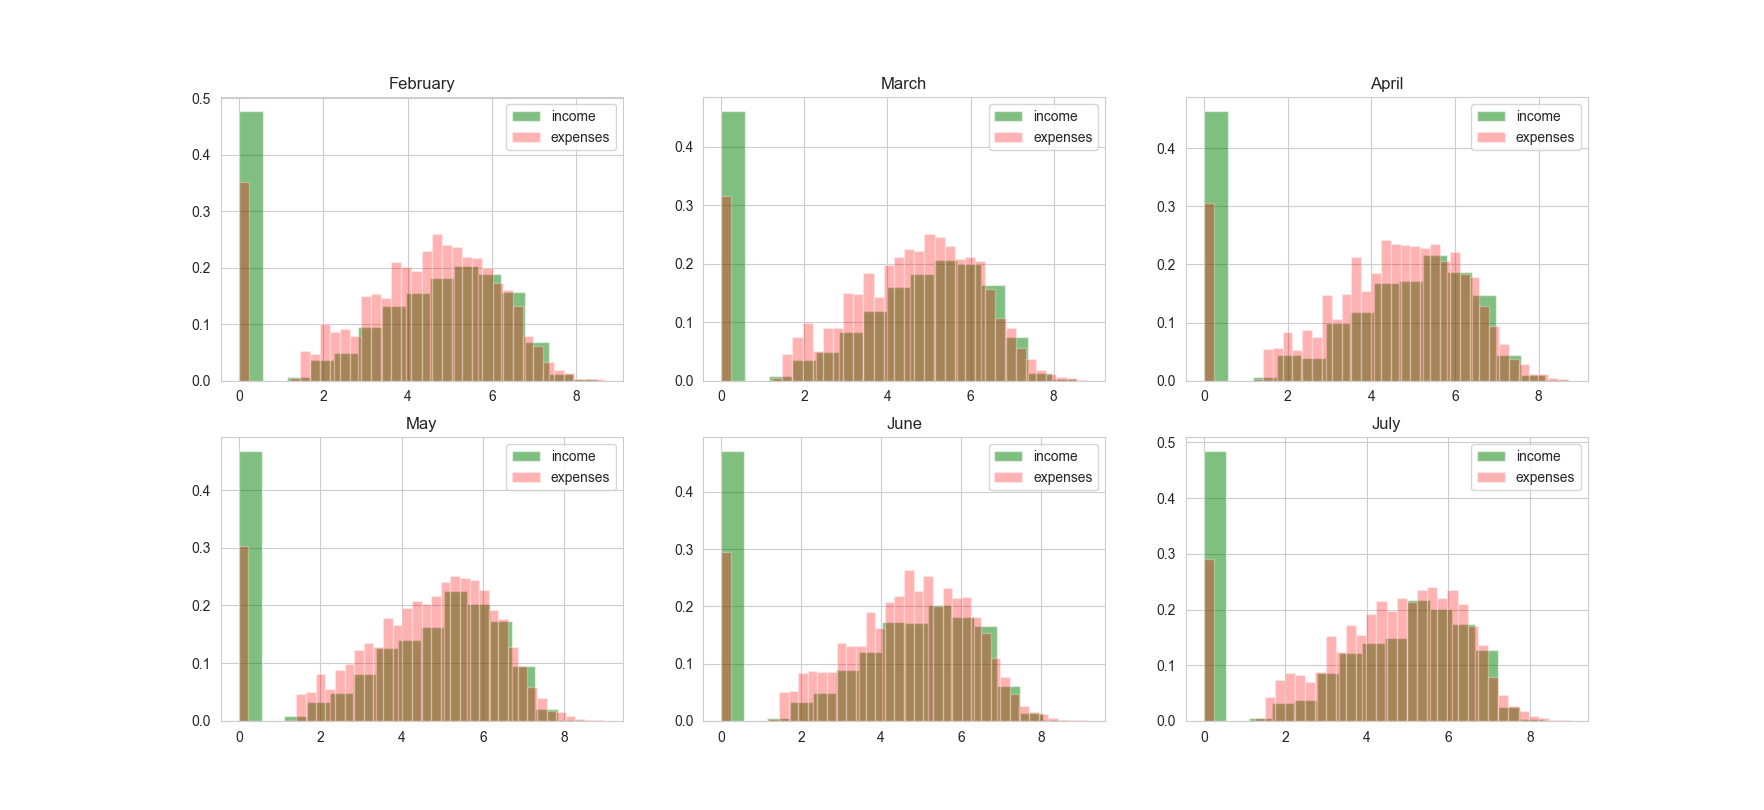

In [9]:
plot_monthly_finance_distributions('in', 'out', 'income', 'expenses', log_transform=True)

In [ ]:
plot_monthly_finance_distributions('count_in', 'count_out', '#incoming transactions', '#outgoing transactions')

In [ ]:
plot_week_over_week(direction='in', transaction_type=None)

In [ ]:
plot_week_over_week(direction='out', transaction_type='PT')

In [ ]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(1, 3)

for i, direction in enumerate(['in', 'out', 'net']):
    finances_stats = {}
    finances_stats['mean'] = user_finances.groupby('month')[direction].mean().to_dict()
    for k, v in [('q25', .25), ('q50', .5), ('q75', .75), ('q90', .90)]:
        finances_stats[k] = user_finances.groupby('month')[direction].quantile(v).to_dict()

    for stat, values in finances_stats.items():
        axes[i].plot(months, [values[m] for m in months], label=stat)

    axes[i].set_title(direction)
    axes[i].legend(loc='upper right')

In [ ]:
fig, axes = plt.subplots(2, 1)
plt.suptitle('overall #incoming transactions types')
sns.countplot(ds[in_idx].transaction_type, ax=axes[0])
sns.countplot(ds[out_idx].transaction_type, ax=axes[1])
plt.show()

In [ ]:
tt_by_amount = ds[in_idx].groupby('transaction_type').amount_n26_currency.sum()
sns.barplot(tt_by_amount.index, tt_by_amount.values)
plt.show()

In [ ]:
tt_by_amount = ds[out_idx].groupby('transaction_type').amount_n26_currency.sum()
sns.barplot(tt_by_amount.index, tt_by_amount.values)
plt.show()

## Feature Creation
----
todo

In [217]:
transaction_types = ['PT', 'DT', 'CT', 'DD', 'DR', 'FT', 'BBU', 'BUB', 'TUB']


def compute_transaction_type_features(ds, transaction_types=transaction_types):
    """Computes the amount of times each type was used by the user
    
    The occuring transactions types in our dataset are
    ['PT', 'DT', 'CT', 'DD', 'DR', 'FT', 'BBU', 'BUB', 'TUB']
    """
    feature_vectors = dict()
    groups = ds.groupby(['user_id', 'transaction_type']).transaction_date.count()
    cache = {u: {t: 0 for t in transaction_types} for u in ds.user_id.unique()}
    for (user, t), count in zip(groups.index, groups.values):
        cache[user][t] += count
        
    for user, counts in cache.items():
        feature_vectors[user] = [counts[t] for t in transaction_types]
    return feature_vectors


def compute_transaction_freq_features(ds, daysinmonth):
    """Computes statistics like the mean transaction frequency per day
    In and Out transactions are not being treated differently
    
    Stats computed: mean, max, 90th percentile
    """
    # there is some duplication here, but we'd like those function to be atomic
    feature_vectors = dict()
    groups = ds.groupby(['user_id', 'transaction_date']).transaction_date.count()
    cache = defaultdict(list)
    for (user, date), count in zip(groups.index, groups.values):
        cache[user].append(count)
    
    for user in ds.user_id.unique():
        transactions_per_day = cache[user] + [0 for _ in range(daysinmonth - len(cache[user]))]
        feature_vectors[user] = [
            np.mean(transactions_per_day),
            np.max(transactions_per_day),
            np.percentile(transactions_per_day, 90),
        ]
    return feature_vectors


def compute_dayofweek_histogram(ds):
    """Computes two histograms corresponding to Incoming/Outgoing amount per day of week
    Since a user can have only In or Out transaction, an vector of all zeros is a possible output
    """
    groups = ds.groupby(['user_id', 'transaction_date', 'transaction_direction']).amount_n26_currency.sum()
    week_in_dist, week_out_dist = dict(), dict()
    
    for (user, date, direction), amount in zip(groups.index, groups.values):
        dist = week_in_dist if direction == 'In' else week_out_dist
        if user not in dist:
            dist[user] = [0 for _ in range(7)]
        dist[user][date.dayofweek] += amount
    
    for user in ds.user_id.unique():
        for dist in [week_in_dist, week_out_dist]:
            if user not in dist:
                dist[user] = [0 for _ in range(7)]
            else:
                total = sum(dist[user])
                dist[user] = [v / total for v in dist[user]]
    return week_in_dist, week_out_dist

                
def compute_quarter_histogram(ds):
    """Computes two histograms with 4 bins. Each bin corresponds to a quarter of the month.
    We naively split the month in four buckets i.e. [1-7, 8-14, 15-21, 21-end]. This creates
    an inconsistency with regards to the last bucket. A better al could be to split based
    on week on the month.
    """
    def quarter_in_month(day):
        if day <= 7:
            return 0
        elif day <= 14:
            return 1
        elif day <= 21:
            return 2
        else:
            return 3
    groups = ds.groupby(['user_id', 'transaction_date', 'transaction_direction']).amount_n26_currency.sum()
    quart_in_dist, quart_out_dist = dict(), dict()
    
    for (user, date, direction), amount in zip(groups.index, groups.values):
        dist = quart_in_dist if direction == 'In' else quart_out_dist
        if user not in dist:
            dist[user] = [0 for _ in range(4)]
        dist[user][quarter_in_month(date.day)] += amount
    
    for user in ds.user_id.unique():
        for dist in [quart_in_dist, quart_out_dist]:
            if user not in dist:
                dist[user] = [0 for _ in range(4)]
            else:
                total = sum(dist[user])
                dist[user] = [v / total for v in dist[user]]
    return quart_in_dist, quart_out_dist

In [233]:
def compute_feature_vectors(ds):
    """Invokes all the feature calculation methods and creates
    a single feature vector for each (month, user) pair
    """
    feature_vectors = {m: defaultdict(list) for m in months}
    occuring_transaction_types = ds.transaction_type.unique()

    for month in ds.month.unique():
        _ds = ds[ds.month == month]
        daysinmonth = _ds.transaction_date.iloc[0].daysinmonth
    
        # Features: counts of transactions types per user per month
        transaction_type_features = compute_transaction_type_features(_ds)
        # Features: stats on transaction frequency (combined In/Out)
        transaction_freq_features = compute_transaction_freq_features(_ds, daysinmonth)
        # Features: histograms for day of week of In/Out transactions
        dayofweek_histograms = compute_dayofweek_histogram(_ds)
        # Features: histograms for quarter of the month In/Out transactions
        quarter_histograms = compute_quarter_histogram(_ds)

        for user in _ds.user_id.unique():
            feature_vectors[month][user] += transaction_type_features[user]
            feature_vectors[month][user] += transaction_freq_features[user]
            feature_vectors[month][user] += dayofweek_histograms[0][user]
            feature_vectors[month][user] += dayofweek_histograms[1][user]
            feature_vectors[month][user] += quarter_histograms[0][user]
            feature_vectors[month][user] += quarter_histograms[1][user]
    return feature_vectors

<IPython.core.display.Javascript object>


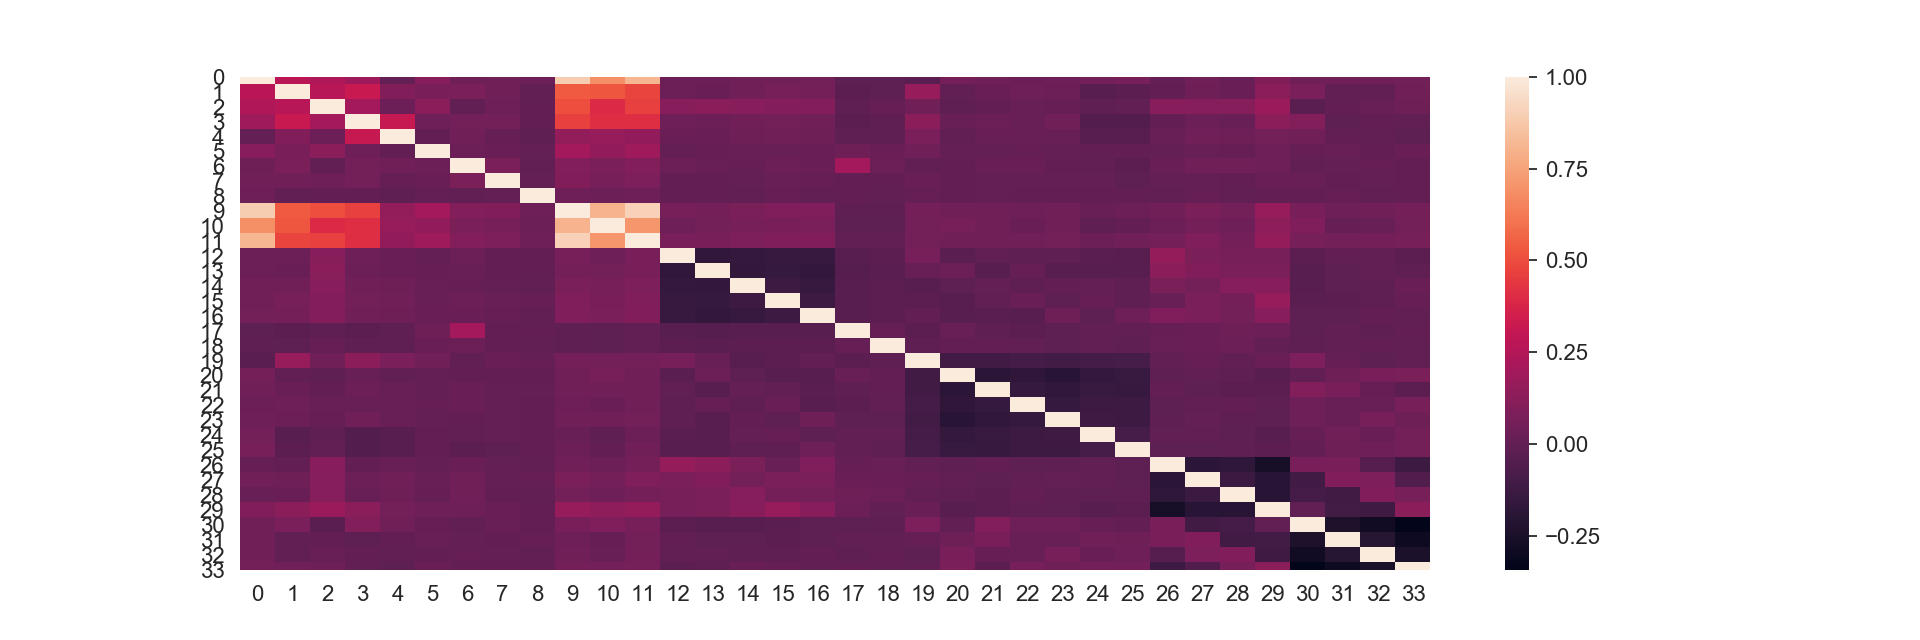

In [234]:
feature_vectors = compute_feature_vectors(ds)

features = []
for month in feature_vectors:
    for user in feature_vectors[month]:
        features.append(feature_vectors[month][user])

corr = pd.DataFrame(features).corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [170]:
metric_labels = {0: 'low', 1: 'student', 2: 'medium', 3: 'high'}

def finance_status_accuracy(y_true, y_pred):
    def category(income):
        if income <= 150:
            return 0
        elif income <= 500:
            return 1
        elif income <= 1500:
            return 2
        else:
            return 3
    
    y_true = np.array(list(map(category, y_true)))
    y_pred = np.array(list(map(category, y_pred)))
    result = {}
    for k, v in metric_labels.items():
        mask = y_true == k
        correct = (y_true[mask] == y_pred[mask]).astype(int)
        result[v] = round(np.sum(correct) / correct.shape[0], 4), y_true[mask].shape[0]
    return result


def preciness(y_true, y_pred, threshold=.2):
    """Measures the percentage of times our predictions was in the range [true +/- true + (true * threshold)]
    """
    y_true_upper = y_true + y_true * threshold
    y_true_lower = y_true - y_true * threshold
    
    correct = np.logical_and(y_pred >= y_true_lower, y_pred <= y_true_upper).astype(int)
    return np.sum(correct) / correct.shape[0]

In [178]:
classifiers = {
    'baseline': None,  # our baseline predictor will be returning the median of the training set
    'rf': RandomForestRegressor(n_estimators=450, max_depth=10, max_features=10, min_samples_leaf=4, random_state=42),    
}

In [175]:
# holdout sample of users for validation
np.random.seed(42)
holdout_users = set(np.random.choice(user_finances.user_id.unique(), size=1000, replace=False))

In [182]:
rmse = lambda y_t, y_p: np.sqrt(mse(y_t, y_p))
rmsle = lambda y_t, y_p: np.sqrt(msle(y_t, y_p))

log_transform = True  # training the classifier on the log-transformed target variable

# LOO (leave one-month-out approach)
classifiers_perf = {
    classifier: {
        month: {
            'in':  {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
            'out': {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
        } for month in months
    } for classifier in classifiers.keys()
}

for month in months:
    _user_finances = user_finances.copy()
    if log_transform:
        _user_finances['in'] = _user_finances.copy()['in'].apply(lambda f: np.log1p(f))
        _user_finances['out'] = _user_finances.copy()['out'].apply(lambda f: np.log1p(f))

    train = _user_finances[(_user_finances.month != month) & ~_user_finances.user_id.isin(holdout_users)]
    val = _user_finances[(_user_finances.month == month) & ~_user_finances.user_id.isin(holdout_users)]
    test = _user_finances[(_user_finances.month == month) & _user_finances.user_id.isin(holdout_users)]
    
    y_train_in, y_train_out = train['in'].values, train['out'].values
    y_val_in, y_val_out = val['in'].values, val['out'].values
    y_test_in, y_test_out = test['in'].values,  test['out'].values

    X_train, X_val, X_test = [], [], []
    for features, dataset in [(X_train, train), (X_val, val), (X_test, test)]:
        for m, u in zip(dataset.month.values, dataset.user_id.values):
            features.append(transaction_features[m][u] + transaction_freq_features[m][u])
    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    
    for name, clf in classifiers.items():
        if name != 'baseline':
            clf_in, clf_out = clone(clf), clone(clf)
            clf_in.fit(X_train, y_train_in)
            clf_out.fit(X_train, y_train_out)
            
        for k, features, target_in, target_out in [
            ('train', X_train, y_train_in, y_train_out),
            ('validation', X_val, y_val_in, y_val_out),
            ('holdout', X_test, y_test_in, y_test_out),
        ]:
            if name == 'baseline':
                y_predict_in = np.full(target_in.shape, np.median(y_train_in))
                y_predict_out = np.full(target_out.shape, np.median(y_train_out))
            else:
                y_predict_in = clf_in.predict(features)
                y_predict_out = clf_out.predict(features)

            if log_transform:
                target_in = np.exp(target_in) - 1
                target_out = np.exp(target_out) - 1
                y_predict_in = np.exp(y_predict_in) - 1
                y_predict_out = np.exp(y_predict_out) - 1
                
            for metric, func in [
                ('mae', mae), ('rmsle', rmsle), ('r2', r2_score), ('finance_status_accuracy', finance_status_accuracy),
                ('preciseness', preciness)
            ]:
                classifiers_perf[name][month]['in'][k][metric] = func(target_in, y_predict_in)
                classifiers_perf[name][month]['out'][k][metric] = func(target_out, y_predict_out)

            classifiers_perf[name][month]['in'][k]['residuals'] = target_in - y_predict_in
            classifiers_perf[name][month]['out'][k]['residuals'] = target_out - y_predict_out
            
            # storing the models for later use
            if name != 'baseline':
                classifiers_perf[name][month]['in']['model'] = clf_in
                classifiers_perf[name][month]['out']['model'] = clf_out

## Evaluate model on Holdout Dataset

In [252]:
# using the RandomForest model that was trained on months Feb-June
income_predictor = classifiers_perf['rf']['July']['in']['model']
expenses_predictor = classifiers_perf['rf']['July']['out']['model']


def evaluate_algorithm(income_predictor, expenses_predictor, ds=None):
    # XXX: test this
    if isinstance(ds, str):
        if dataset.endswith('.csv'):
            ds = pd.read_csv(ds)
            ds = transform_dataset(ds)
    # creating the dataset with target vars. The targets are the aggregated
    # incoming and outgoing amounts for each user each month
    user_finances, _, _ = create_income_expenses_df(ds)
    
    # log transforming the target vars to mitigate skewed distribution
    user_finances['in'] = user_finances.copy()['in'].apply(lambda f: np.log1p(f))
    user_finances['out'] = user_finances.copy()['out'].apply(lambda f: np.log1p(f))
    
    feature_vectors = compute_feature_vectors(ds)
    X = []
    for m, u in zip(user_finances.month.values, user_finances.user_id.values):
        X.append(feature_vectors[m][u])
    X = np.array(X)
    
    y_pred_in = income_predictor.predict(X)
    y_pred_out = expenses_predictor.predict(X)
    
    for y_true, y_pred in [(y_pred_in, user_finances['in']), (y_pred_out, user_finances['out'])]:
        y_true, y_pred = np.exp(y_true) - 1, np.exp(y_pred) - 1
        print(round(mae(y_true, y_pred), 4))
        print(round(rmsle(y_true, y_pred), 4))
        print(round(r2_score(y_true, y_pred), 4))
        print(round(preciness(y_true, y_pred), 4))
        print(finance_status_accuracy(y_true, y_pred))

evaluate_algorithm(income_predictor, expenses_predictor, ds[ds.month == 'March'])

132.7562
0.8628
-1.4788
0.1257
{'low': (0.8244, 4766), 'student': (0.4718, 2253), 'medium': (0.6181, 419), 'high': (nan, 0)}
126.23
0.7666
-0.583
0.187
{'low': (0.8428, 4580), 'student': (0.5721, 2108), 'medium': (0.5929, 732), 'high': (0.7222, 18)}


/Users/gryllos/n26_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [63]:
def plot_performance(metric='rmsle'):
    plt.rcParams['figure.figsize'] = (12, 4)
    plt.rcParams['figure.dpi'] = 80

    fig, axes = plt.subplots(1, 2)

    mean_score = {k: {0: {}, 1: {}} for k in classifiers_perf}
    for clf in classifiers_perf:
        _color = 'C0' if clf == 'baseline' else 'C1'
        for i in range(2):
            for symbol, alpha, k in [('-^', .4, 'train'), ('-*', .5,'validation'), ('-o', .8,'holdout')]:
                score = []
                for month in months:
                    score.append(classifiers_perf[clf][month]['in' if i == 0 else 'out'][k][metric]) 
                mean_score[clf][i][k] = np.mean(score), np.std(score)
                axes[i].plot(months, score, symbol, color=_color, label='{}_{}'.format(clf, k), alpha=alpha)
                axes[i].legend()
                axes[i].set_xlabel('Holdout Month')
                axes[i].set_ylabel(metric.upper())
                axes[i].set_title('{} predictor {}'.format('income' if i == 0 else 'expenses', metric.upper()))
    plt.show()

    for name, i in [('Income', 0), ('Expenses', 1)]:
        for clf in mean_score:
            print ('{} {} Predictor {} score'.format(clf.upper(), name, metric.upper()))
            print ('Train \t\tmean {} std {}\nValidation \tmean {} std {}\nHoldout \tmean {} std {}\n'.format(
                round(mean_score[clf][i]['train'][0], 2), round(mean_score[clf][i]['train'][1], 2),
                round(mean_score[clf][i]['validation'][0], 2), round(mean_score[clf][i]['validation'][1], 2),
                round(mean_score[clf][i]['holdout'][0], 2), round(mean_score[clf][i]['holdout'][1], 2)
            ))

<IPython.core.display.Javascript object>


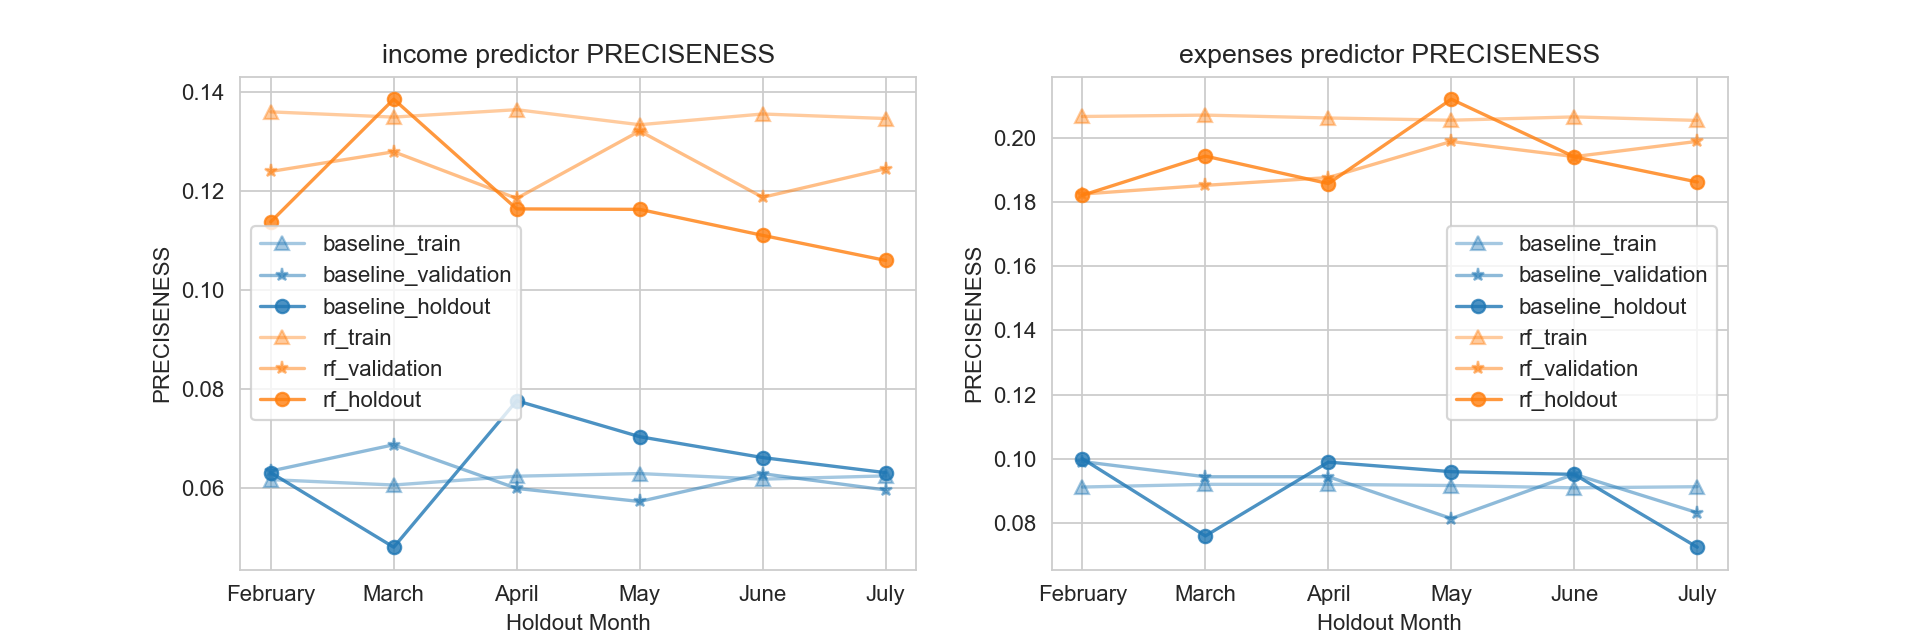

BASELINE Income Predictor PRECISENESS score
Train 		mean 0.06 std 0.0
Validation 	mean 0.06 std 0.0
Holdout 	mean 0.06 std 0.01

RF Income Predictor PRECISENESS score
Train 		mean 0.14 std 0.0
Validation 	mean 0.12 std 0.0
Holdout 	mean 0.12 std 0.01

BASELINE Expenses Predictor PRECISENESS score
Train 		mean 0.09 std 0.0
Validation 	mean 0.09 std 0.01
Holdout 	mean 0.09 std 0.01

RF Expenses Predictor PRECISENESS score
Train 		mean 0.21 std 0.0
Validation 	mean 0.19 std 0.01
Holdout 	mean 0.19 std 0.01



In [180]:
plot_performance('preciseness')

In [84]:
for clf in classifiers_perf:
    for i in ['in', 'out']:
        acc_low, acc_student, acc_medium, acc_high = [], [], [], []
        for month in months:
            acc = classifiers_perf[clf][month][i]['holdout']['finance_status_accuracy']
            for k, _acc in [('low', acc_low), ('student', acc_student), ('medium', acc_medium), ('high', acc_high)]:
                _acc.append(acc[k])

        print ('\n{} {} Predictor Finance Status Accuracy'.format(clf.upper(), 'Income' if i == 'in' else 'Expenses'))
        for k, _acc in [('low', acc_low), ('student', acc_student), ('medium', acc_medium), ('high', acc_high)]:
            print ('category {} \tmean accuracy {} mean sample size {}'.format(
                k, round(np.mean([a for a, n in _acc]), 2), int(np.mean([n for a, n in _acc]))
            ))


BASELINE Income Predictor Finance Status Accuracy
category low 	mean accuracy 1.0 mean sample size 451
category student 	mean accuracy 0.0 mean sample size 187
category medium 	mean accuracy 0.0 mean sample size 101
category high 	mean accuracy 0.0 mean sample size 5

BASELINE Expenses Predictor Finance Status Accuracy
category low 	mean accuracy 1.0 mean sample size 430
category student 	mean accuracy 0.0 mean sample size 208
category medium 	mean accuracy 0.0 mean sample size 92
category high 	mean accuracy 0.0 mean sample size 14

RF Income Predictor Finance Status Accuracy
category low 	mean accuracy 0.87 mean sample size 451
category student 	mean accuracy 0.58 mean sample size 187
category medium 	mean accuracy 0.24 mean sample size 101
category high 	mean accuracy 0.0 mean sample size 5

RF Expenses Predictor Finance Status Accuracy
category low 	mean accuracy 0.89 mean sample size 430
category student 	mean accuracy 0.63 mean sample size 208
category medium 	mean accuracy 0.45

<IPython.core.display.Javascript object>


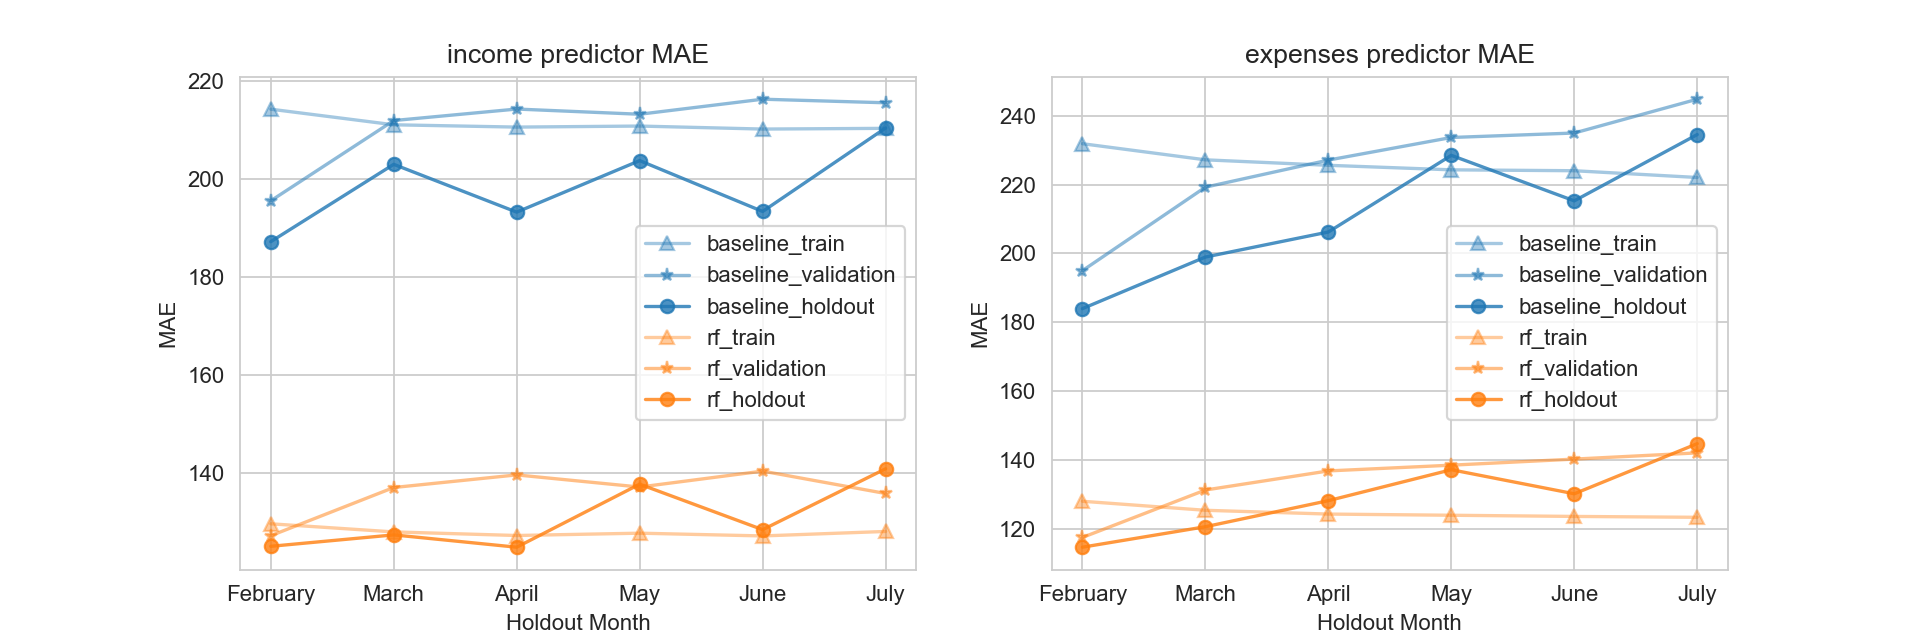

BASELINE Income Predictor MAE score
Train 		mean 211.12 std 1.39
Validation 	mean 211.05 std 7.11
Holdout 	mean 198.43 std 7.86

RF Income Predictor MAE score
Train 		mean 127.98 std 0.82
Validation 	mean 136.2 std 4.31
Holdout 	mean 130.72 std 6.25

BASELINE Expenses Predictor MAE score
Train 		mean 225.81 std 3.11
Validation 	mean 225.77 std 15.8
Holdout 	mean 211.23 std 17.19

RF Expenses Predictor MAE score
Train 		mean 124.88 std 1.59
Validation 	mean 134.5 std 8.27
Holdout 	mean 129.37 std 9.92



In [66]:
plot_performance('mae')

<IPython.core.display.Javascript object>


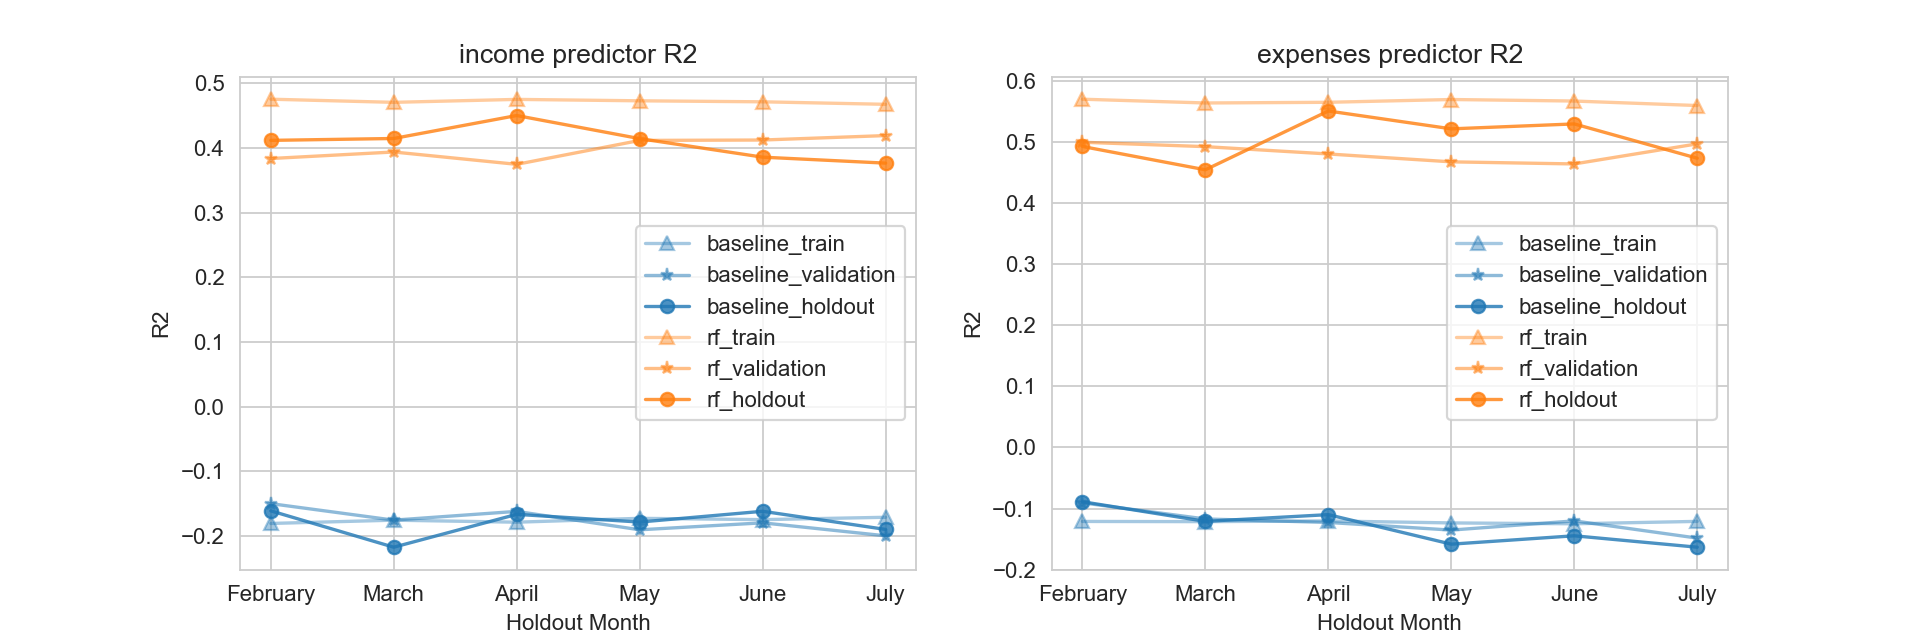

BASELINE Income Predictor R2 score
Train 		mean -0.18 std 0.0
Validation 	mean -0.18 std 0.02
Holdout 	mean -0.18 std 0.02

RF Income Predictor R2 score
Train 		mean 0.47 std 0.0
Validation 	mean 0.4 std 0.02
Holdout 	mean 0.41 std 0.02

BASELINE Expenses Predictor R2 score
Train 		mean -0.12 std 0.0
Validation 	mean -0.12 std 0.02
Holdout 	mean -0.13 std 0.03

RF Expenses Predictor R2 score
Train 		mean 0.57 std 0.0
Validation 	mean 0.48 std 0.01
Holdout 	mean 0.5 std 0.03



'\nBASELINE Income Predictor R2 score\nTrain \t\tmean -0.18 std 0.0\nValidation \tmean -0.18 std 0.02\nHoldout \tmean -0.18 std 0.02\n\nRF Income Predictor R2 score\nTrain \t\tmean 0.45 std 0.0\nValidation \tmean 0.4 std 0.01\nHoldout \tmean 0.39 std 0.02\n\nBASELINE Expenses Predictor R2 score\nTrain \t\tmean -0.12 std 0.0\nValidation \tmean -0.12 std 0.02\nHoldout \tmean -0.13 std 0.03\n\nRF Expenses Predictor R2 score\nTrain \t\tmean 0.55 std 0.0\nValidation \tmean 0.49 std 0.01\nHoldout \tmean 0.49 std 0.04\n'

In [253]:
plot_performance('r2')
"""
BASELINE Income Predictor R2 score
Train 		mean -0.18 std 0.0
Validation 	mean -0.18 std 0.02
Holdout 	mean -0.18 std 0.02

RF Income Predictor R2 score
Train 		mean 0.45 std 0.0
Validation 	mean 0.4 std 0.01
Holdout 	mean 0.39 std 0.02

BASELINE Expenses Predictor R2 score
Train 		mean -0.12 std 0.0
Validation 	mean -0.12 std 0.02
Holdout 	mean -0.13 std 0.03

RF Expenses Predictor R2 score
Train 		mean 0.55 std 0.0
Validation 	mean 0.49 std 0.01
Holdout 	mean 0.49 std 0.04
"""

In [ ]:
BASELINE Income Predictor R2 score
Train 		mean -0.18 std 0.0
Validation 	mean -0.18 std 0.02
Holdout 	mean -0.18 std 0.02

RF Income Predictor R2 score
Train 		mean 0.34 std 0.0
Validation 	mean 0.33 std 0.02
Holdout 	mean 0.35 std 0.04

BASELINE Expenses Predictor R2 score
Train 		mean -0.12 std 0.0
Validation 	mean -0.12 std 0.02
Holdout 	mean -0.13 std 0.03

RF Expenses Predictor R2 score
Train 		mean 0.43 std 0.0
Validation 	mean 0.43 std 0.02
Holdout 	mean 0.45 std 0.03


In [ ]:
def plot_residual_distribution(in_or_out):
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['figure.dpi'] = 80

    fig, axes = plt.subplots(2, 3)
    plt.suptitle('Distributions of residual for {} classifier'.format('Income' if in_or_out == 'in' else 'Expenses'))
    for i, month in enumerate(['February', 'March', 'April', 'May', 'June', 'July']):
        _axes = axes[i // 3, i % 3]
        for clf in classifiers_perf:
            sns.distplot(
                classifiers_perf[clf][month][in_or_out]['holdout']['residuals'], hist_kws={'alpha': 0.5},
                hist=True, label=clf, kde=False, norm_hist=True, ax=_axes
            )
        _axes.set_title(month)
        _axes.legend()

In [ ]:
plot_residual_distribution('in')

In [ ]:
plot_residual_distribution('out')